In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.utils import img_to_array
from tqdm import tqdm
import numpy as np 
import pandas as pd 
from keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Input, LeakyReLU, BatchNormalization, UpSampling2D, MaxPooling2D
from keras.layers import Concatenate
from keras.optimizers import Adam
import tensorflow as tf

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# # /content/drive/MyDrive/Colab Notebooks/archive.zip

In [3]:
import zipfile
# from google.colab import drive


zip_ref = zipfile.ZipFile("archive.zip", 'r')
zip_ref.extractall("")
zip_ref.close()

In [4]:
SIZE = 160
color_img = []
path = 'landscape Images/color'
files = os.listdir(path)
for i in tqdm(files):    
    img = cv2.imread(path + '/'+i,1)
    # open cv reads images in BGR format so we have to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    color_img.append(img_to_array(img))


gray_img = []
path = 'landscape Images/gray'
files = os.listdir(path)
for i in tqdm(files):

    img = cv2.imread(path + '/'+i,1)
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    gray_img.append(img_to_array(img))

100%|█████████████████████████████████████| 7129/7129 [00:02<00:00, 2620.91it/s]


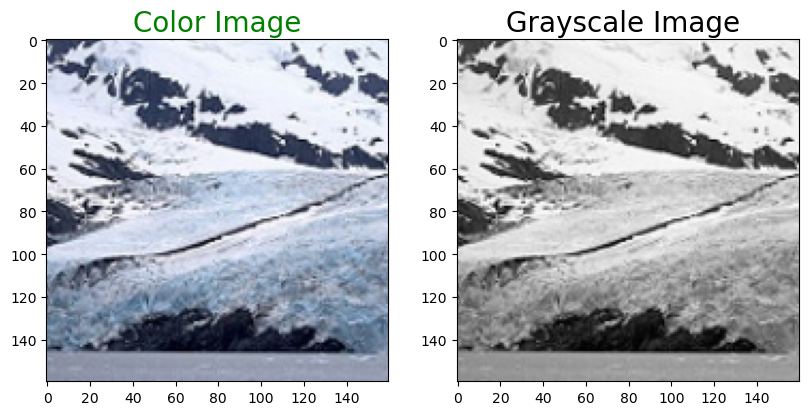

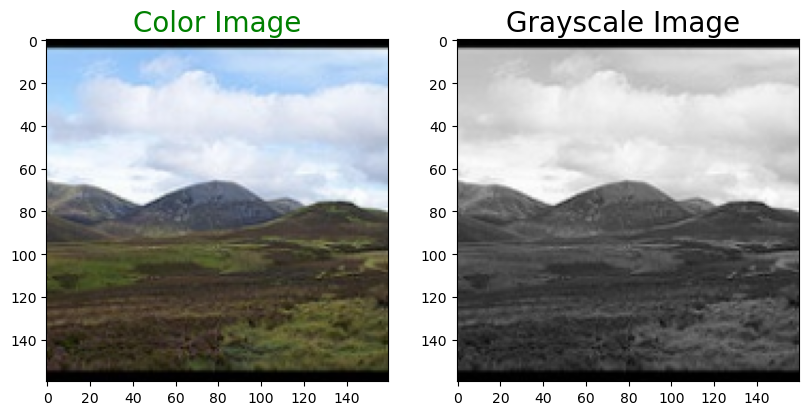

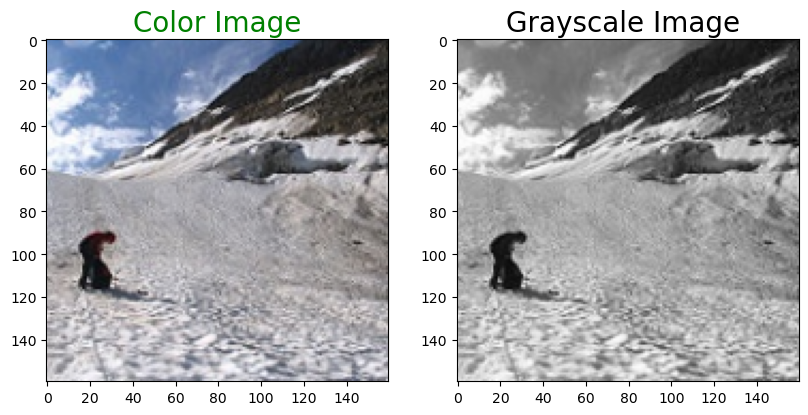

In [5]:
for i in range(45,48):
    color = color_img[i]
    grayscale= gray_img[i]
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

In [6]:
train_gray_image = gray_img[:5500]
train_color_image = color_img[:5500]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5500, 160, 160, 3)
Test color image shape (1629, 160, 160, 3)


In [7]:
import keras
from keras import layers
def encoder(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample
def decoder(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample


In [8]:
def model():
    # downsampling
    inputs = layers.Input(shape= [160,160,3])
    d1 = encoder(128,(3,3),False)(inputs)
    d2 = encoder(128,(3,3),False)(d1)
    d3 = encoder(256,(3,3),True)(d2)
    d4 = encoder(512,(3,3),True)(d3)
    d5 = encoder(512,(3,3),True)(d4)
    #upsampling
    u1 = decoder(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = decoder(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = decoder(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = decoder(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = decoder(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [9]:
model = model()
model.summary()

Metal device set to: Apple M2 Pro
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192 

In [12]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001), loss = 'mean_absolute_error',
              metrics = ['acc'])

history = model.fit(train_g, train_c, epochs = 50,batch_size = 8,verbose = 1)

Epoch 1/50
688/688 [==============================] - 51s 72ms/step - loss: 0.0724 - acc: 0.4459
Epoch 2/50
688/688 [==============================] - 2421s 4s/step - loss: 0.0624 - acc: 0.4647
Epoch 3/50
688/688 [==============================] - 2283s 3s/step - loss: 0.0569 - acc: 0.4794
Epoch 4/50
688/688 [==============================] - 671s 976ms/step - loss: 0.0541 - acc: 0.4871
Epoch 5/50
688/688 [==============================] - 48s 69ms/step - loss: 0.0521 - acc: 0.4947
Epoch 6/50
688/688 [==============================] - 48s 69ms/step - loss: 0.0505 - acc: 0.4995
Epoch 7/50
688/688 [==============================] - 48s 69ms/step - loss: 0.0497 - acc: 0.5011
Epoch 8/50
688/688 [==============================] - 48s 69ms/step - loss: 0.0486 - acc: 0.5092
Epoch 9/50
688/688 [==============================] - 48s 70ms/step - loss: 0.0479 - acc: 0.5153
Epoch 10/50
688/688 [==============================] - 220s 321ms/step - loss: 0.0471 - acc: 0.5223
Epoch 11/50
688/688 [====

In [13]:
model.evaluate(test_gray_image,test_color_image)

51/51 [==============================] - 7s 129ms/step - loss: 0.0484 - acc: 0.5142


[0.04836982116103172, 0.514248251914978]

In [7]:
model.save('initial_model')
# 116.2 MB

NameError: name 'model' is not defined

1/1 [==============================] - 1s 745ms/step


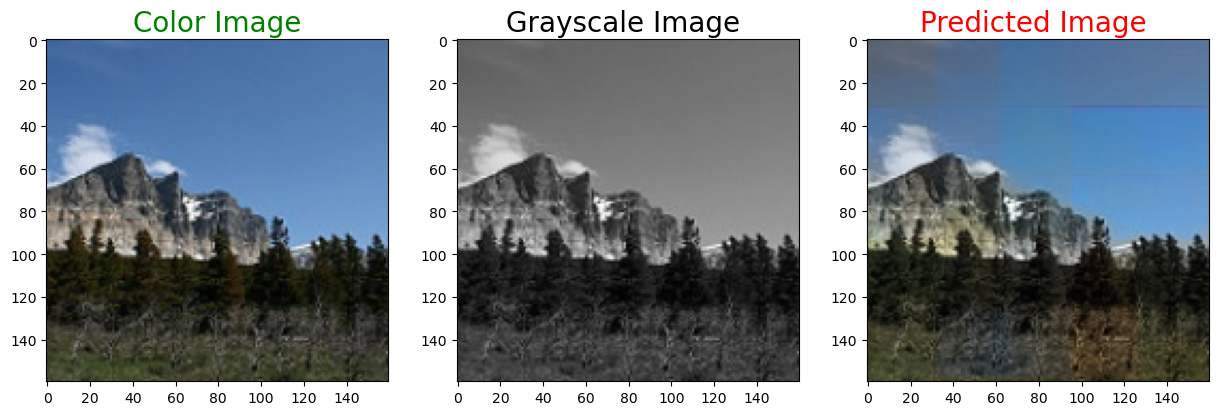

1/1 [==============================] - 0s 37ms/step


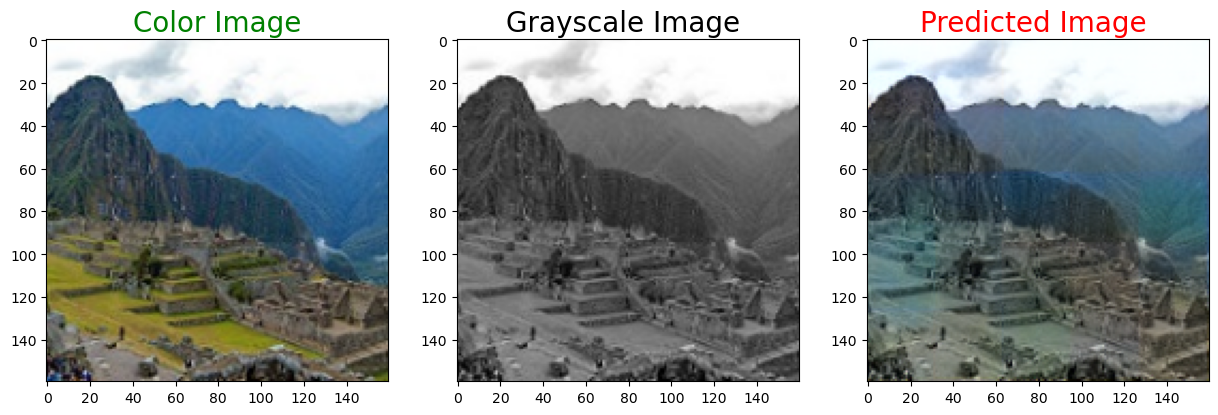

1/1 [==============================] - 0s 23ms/step


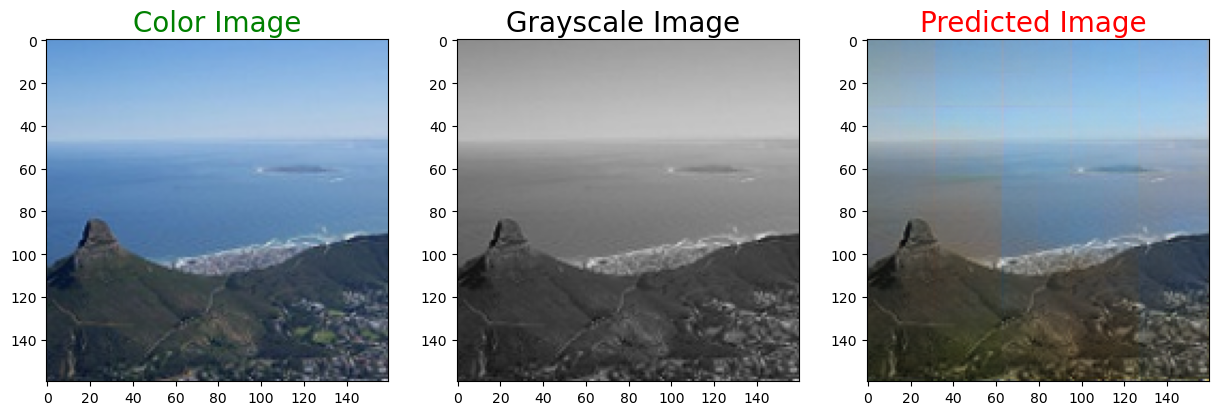

1/1 [==============================] - 0s 20ms/step


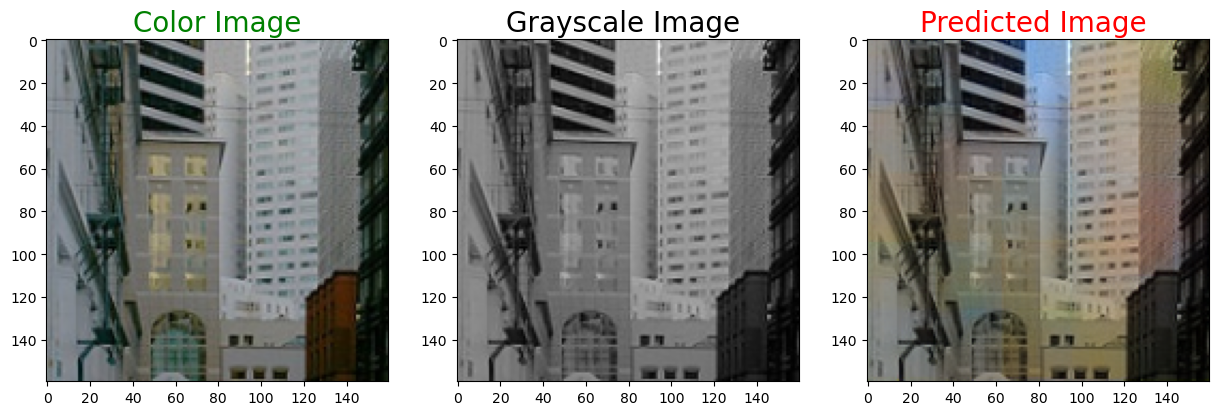

1/1 [==============================] - 0s 11ms/step


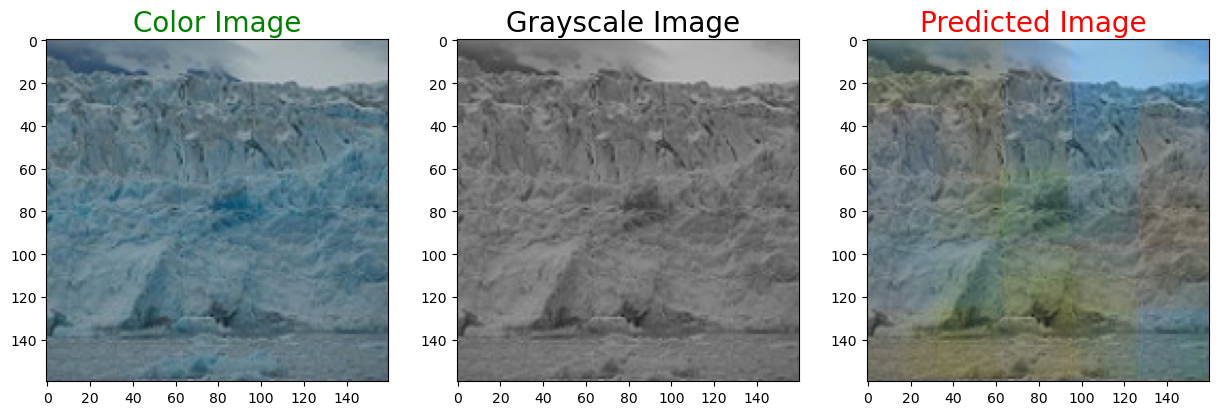

1/1 [==============================] - 0s 12ms/step


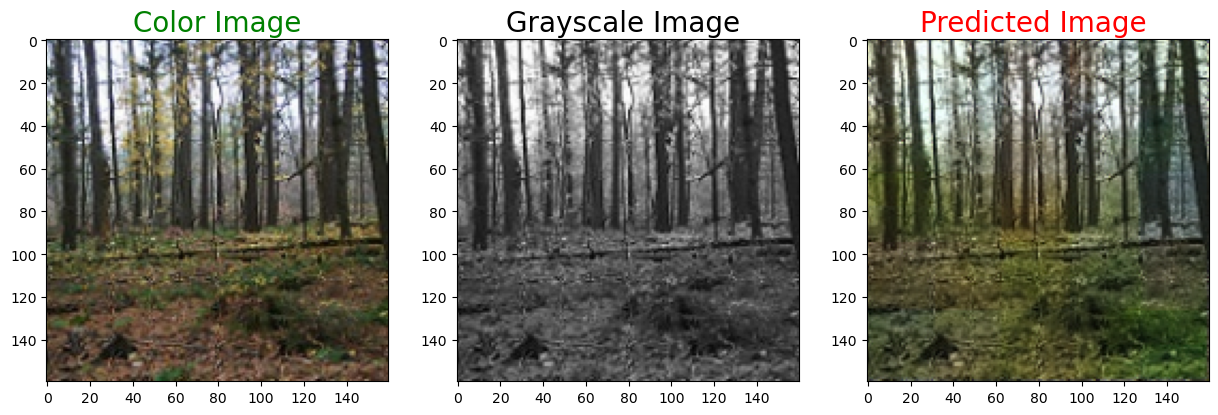

1/1 [==============================] - 0s 11ms/step


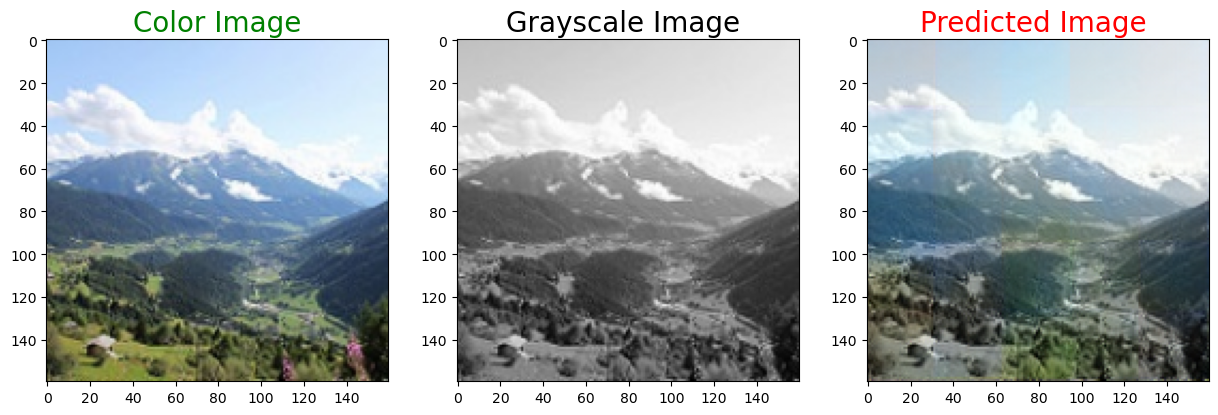

1/1 [==============================] - 0s 11ms/step


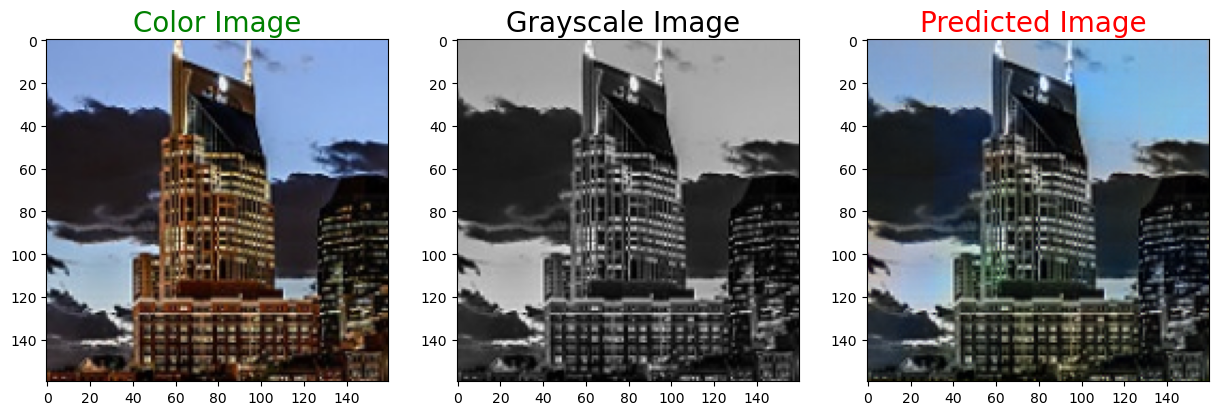

In [15]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

In [8]:
model = tf.keras.models.load_model("initial_model")

Metal device set to: Apple M2 Pro


In [9]:
# initial_model
# Converting a SavedModel to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_saved_model("./initial_model")
tflite_model = converter.convert()

2023-05-07 14:50:22.997739: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-07 14:50:22.997967: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-07 14:50:23.012522: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [18]:
# len(tflite_model)
# with open("tflite_model.tflite", "wb") as f:
#     f.write(tflite_model)

In [10]:
model = tf.keras.models.load_model("initial_model")

In [16]:
quant_aware_model = tfmot.quantization.keras.quantize_model(model)

ValueError: Quantizing a tf.keras Model inside another tf.keras Model is not supported.

In [13]:
import tensorflow_model_optimization as tfmot
from PIL import Image


img_dir="IMG_4263.jpg"
img = Image.open(img_dir)


interpreter = tf.lite.Interpreter(model_path=str("initial_model"))
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, img)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

ValueError: Mmap of '102' at offset '0' failed with error '22'.

In [ ]:

quant_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001), loss = 'mean_absolute_error',
              metrics = ['val_acc'])
quant_model.summary()

In [1]:
# Binary Quantization
model_q2 = model
for layer in model_q2.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        weights[0][weights[0] <= 0] = -1
        weights[0][weights[0] > 0] = 1
        layer.set_weights(weights)

y_pred = model_q2.predict(train_c)
y_pred = (y_pred > 0.5)

model_q2.save('binary_quaantized_model')

model_q2.evaluate(test_gray_image,test_color_image)

NameError: name 'model' is not defined

In [5]:
# Applying quantization on tflite model since tflite reduces accuracy

converter.optimization = [tf.lite.optimizations.DEFAULT]
quantized_model = converter.convert()

AttributeError: module 'tensorflow' has no attribute 'lit'

In [19]:
from numpy import save
save('history.npy', history)

In [ ]:
# import tensorflow_model_optimization as tfmot

# quant = tfmot.quantization.keras.quantize_model

# q_model = quant(model)

# q_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001), loss = 'mean_absolute_error',
#               metrics = ['acc'])
# q_model.summary()

In [12]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.utils import img_to_array, array_to_img
import matplotlib.pyplot as plt
import cv2
SIZE=160
def convert_images_to_bw(folder_path):
    image_array = []

    for filename in os.listdir(folder_path):
        # if filename.endswith('.jpg') or filename.endswith('.png'):  # Filter image files
        image_path = os.path.join(folder_path, filename)

        # Open image and convert to black and white
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32')/255.0
        # Convert image to numpy array
        image_array.append(img_to_array(img))

    return (image_array)

def read_color(folder_path):
    image_array = []

    for filename in os.listdir(folder_path):
        # if filename.endswith('.jpg') or filename.endswith('.png'):  # Filter image files
        image_path = os.path.join(folder_path, filename)
        # Open image and convert to black and white
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert image to numpy array
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32')/255.0
        image_array.append(img_to_array(img))

    return (image_array)


In [13]:
# Convert images to black and white and save as array
train_gray_image = convert_images_to_bw('afhq/combine')
train_color_image = read_color('afhq/combine')
print("Trainging data loaded")
from sklearn.utils import resample
train_gray_image, train_color_image = resample(train_gray_image, train_color_image)

test_color_image = read_color('afhq/combine_val')
test_gray_image = convert_images_to_bw('afhq/combine_val')

test_color_image, test_gray_image = resample(test_color_image, test_gray_image)

print("Testing data loaded")



Trainging data loaded
Testing data loaded


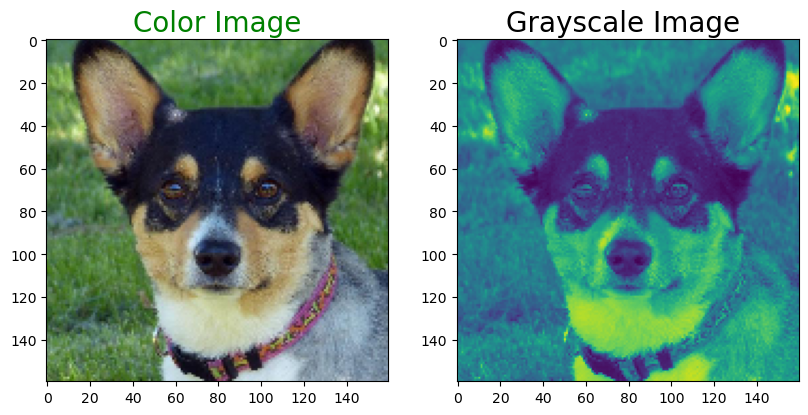

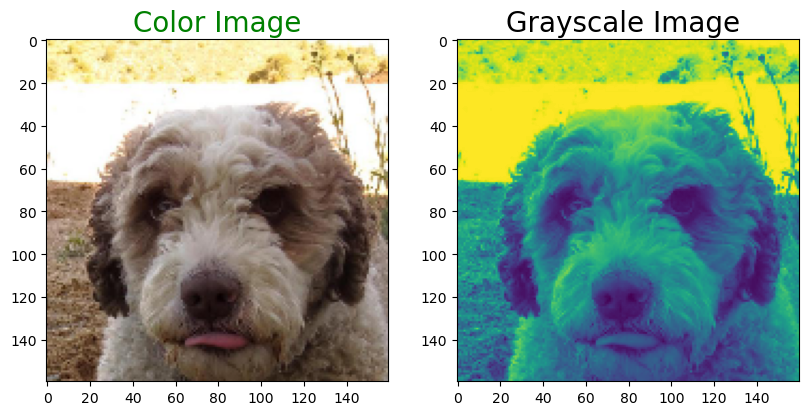

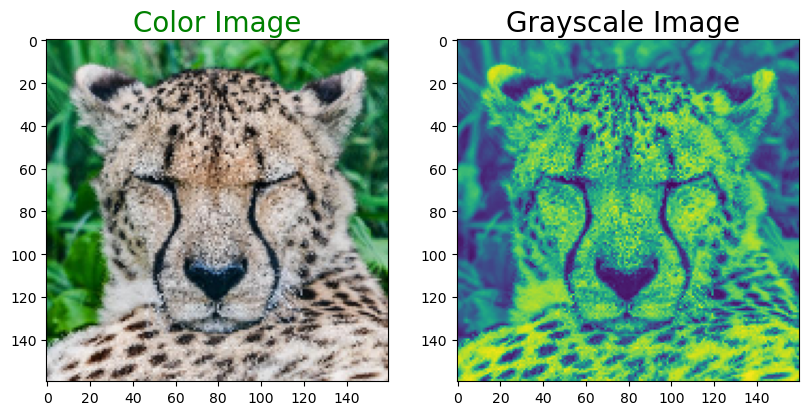

In [14]:
for i in range(45, 48):
    color =train_color_image[i]
    grayscale = train_gray_image[i]
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Color Image', color='green', fontsize=20)
    plt.imshow(color)
    plt.subplot(1, 3, 2)
    plt.title('Grayscale Image ', color='black', fontsize=20)
    plt.imshow(grayscale)

    plt.show()

In [8]:
np.array(train_color_image).shape

(14630, 160, 160, 3)